In [1]:
# import dependencies 
import numpy as np
import pandas as pd 
import time
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, log_loss, confusion_matrix 
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.base import TransformerMixin, BaseEstimator
import matplotlib.pyplot as plt
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from processing_scripts import data_pipelines as dp
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
%matplotlib inline

# define folder where data resides 
DATAFOLDER = "/Users/snuffles753/Documents/NYU-GSAS/ds1003/term-project/data"

In [ ]:
# only use a subset of the features for easier processing

import csv
import os
def create_dchen_subset():
    with open(os.path.join(DATAFOLDER,'final_subset.csv'), 'w') as f_write:
        with open(os.path.join(DATAFOLDER,'decision_sched_merge_adjdate.csv'), "r") as f:
            read = csv.DictReader(f, delimiter=',')
            first = True
            for row in read:
                if first:
                    f_write.write("case_id,proceeding_id,year,judge_id,nationality,lawyer,city_id,decision\n")
                    first = False
                else:
                    f_write.write("{},{},{},{},{},{},{},{}\n".format(row['idncase'], row['idnproceeding'],
                                                                  row['input_year'], row['judgeid'],
                                                                  row['nat'],row['lawyer'],row['cityid'],
                                                                  row['dec_string']))

### Clean up the appeals raw dataset

In [2]:
# code lookup tables 
bia_appeal_category = pd.read_excel(os.path.join(DATAFOLDER, 'raw/BIA Appeal Data File code translations.xlsx'), 
                                    sheet_name='BIA Appeal Category', skip_footer=7)
bia_appeal_type = pd.read_excel(os.path.join(DATAFOLDER, 'raw/BIA Appeal Data File code translations.xlsx'),
                                sheet_name='BIA Appeal Type', skip_footer=3)
bia_decision_type = pd.read_excel(os.path.join(DATAFOLDER, 'raw/BIA Appeal Data File code translations.xlsx'),
                                  sheet_name='BIA decision type', skip_footer=2)
bia_decision_code = pd.read_excel(os.path.join(DATAFOLDER, 'raw/BIA Appeal Data File code translations.xlsx'),
                                  sheet_name='BIA decision code', skip_footer=2)

In [3]:
# main table 
tblAppeal = pd.read_csv(os.path.join(DATAFOLDER, 'raw/tblAppeal.csv'), low_memory=False) 
print("raw: " + str(tblAppeal.shape))
tblAppeal = tblAppeal.merge(bia_appeal_category, how='left', left_on='strAppealCategory', right_on='Code')\
                        .rename(columns={'Description': 'strAppealCategoryDesc'}).drop('Code', axis=1)\
                        .merge(bia_appeal_type, how='left', left_on='strAppealType', right_on='Code')\
                        .rename(columns={'Description': 'strAppealTypeDesc'}).drop('Code', axis=1)\
                        .merge(bia_decision_code, how='left', left_on='strBIADecision', right_on='Code')\
                        .rename(columns={'Description': 'strBIADecisionDesc'}).drop('Code', axis=1)\
                        .merge(bia_decision_type, how='left', left_on='strBIADecisionType', right_on='Code')\
                        .rename(columns={'Description': 'strBIADecisionTypeDesc'}).drop('Code', axis=1)
print("post merge: " + str(tblAppeal.shape))
# drop appeals with no case number, proceeding number, or decision 
tblAppeal.dropna(subset=['idncase', 'idnProceeding', 'strBIADecision'], inplace=True) 
tblAppeal = tblAppeal[tblAppeal['idnProceeding'] != 0] # drop zeros 
print(tblAppeal.shape)
tblAppeal = tblAppeal[['idncase', 'idnProceeding', 'strBIADecision', 'strAppealTypeDesc',
                      'strAppealCategoryDesc']]
print(tblAppeal.shape)
# convert indexes to integers 
tblAppeal['idncase'] = tblAppeal['idncase'].astype(int) 
tblAppeal['idnProceeding'] = tblAppeal['idnProceeding'].astype(int) 

# filter relevant appeal types 
selected_appeal_types = ['Appeal of IJ MTR', 'Case Appeal', 'Circuit Court Remand', 'Interlocutory Appeal', 'MTR BIA'] 
appeals_in_scope = tblAppeal[tblAppeal['strAppealTypeDesc'].isin(selected_appeal_types)]
print("in scope appeals: " + str(appeals_in_scope.shape))
appeals_in_scope.head()

raw: (870388, 17)
post merge: (870388, 21)
(755222, 21)
(755222, 5)
in scope appeals: (732486, 5)


,idncase,idnProceeding,strBIADecision,strAppealTypeDesc,strAppealCategoryDesc
0,2068887,130236,SUS,Case Appeal,NaN
1,2078964,147893,OTH,Case Appeal,NaN
2,2078964,147894,OTH,Case Appeal,NaN
3,2081466,153089,SUS,Case Appeal,NaN
4,2084021,156608,REM,Case Appeal,NaN


### Process the Dunn data

In [4]:
dunn_raw = pd.read_csv(os.path.join(DATAFOLDER, 
                                    '_decision_scheduling_merge_final_converted.csv'), 
                       low_memory=False,
                       encoding='latin-1') 
print("raw: " + str(dunn_raw.shape))
dunn_raw.head()

raw: (602500, 182)


,Unnamed: 0,idncase,idnproceeding,nat,case_type,c_asy_type,base_city_code,hearing_loc_code,dec_type,dec_code,other_comp,attorney_flag,ij_code,tracid,case_type_string,_mcase,dec_type_string,_mdectype,outcome_recorded_in_field,dec_string,_mdecproceeddec,_mdecproceedoth,nat_string,_mnat,base_city_street,base_city_string,base_city_state,base_city_zip5,base_city_zip4,base_city_phone,_mbasecity,hearing_loc_string1,hearing_loc_string2,hearing_loc_street,hearing_loc_city,hearing_loc_state,hearing_loc_zip5,hearing_loc_phone,_mhearingloc,judge_name_caps,_mlookupijcode,idncode,idnproceedingappln,appl_code,appl_dec,_mappln,application_type_string,_mapplcode,application_dec_string,_mappldec,...,cal_type_string,_mcaltype,notice_code_string,_mnotice,schedule_type_string,_mschedcodes,adj_completion_prior_to_hearing,adj_case_conversion,adj_alien_to_seek_representation,adj_merits_hearing,adj_to_file,adj_preparation,adj_consolidation_family,government_requested,alien_requested,either_requested,clock_stopped,clock_running,clock_end,individual_cal,multiple_cal,deportation_notice,exclusion_notice,removal_notice,asylum_only_notice,withholding_only_notice,custody_notice,family_notice,initial_notice,individual_sched,multiple_sched,unknown_sched,adj_date_stamp,adj_year,adj_month,adj_day,adj_input_year,adj_input_month,adj_input_day,adj_input_date,adj_osc_year,adj_osc_month,adj_osc_day,adj_osc_date,eoirattyid,alienattyid,langid,hearingid,basecityid,last_hearing_on_comp_date
0,0,3327379,488,IN,DEP,E,NYC,NYC,W,V,NaN,1.0,TAB,135.0,DEPORTATION,matched (3),WRITTEN DECISION,matched (3),C,VOLUNTARY DEPARTURE,matched (3),master only (1),INDIA,matched (3),26 FEDERAL PLZ 12TH FL RM 1237,NEW YORK,NY,10278,0.0,2.122646e+09,matched (3),"NEW YORK CITY, NEW YORK",IMMIGRATION COURT,"26 FEDERAL PLZ 12TH FL.,RM1237",NEW YORK,NY,10278.0,9174541040,matched (3),TERRY A. BAIN,matched (3),487.0,1237,ASYL,D,matched (3),ASYLUM,matched (3),DENY,matched (3),...,INDIVIDUAL,matched (3),NaN,master only (1),UNKNOWN,matched (3),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,13170,1996,1,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44811.0,16732.0,380.0,210.0,36,0
1,1,3327267,886,IN,DEP,E,NEW,NEW,W,D,NaN,1.0,AJR,164.0,DEPORTATION,matched (3),WRITTEN DECISION,matched (3),C,DEPORT,matched (3),master only (1),INDIA,matched (3),"970 BROAD STREET, ROOM 1200",NEWARK,NJ,7102,0.0,9.736454e+09,matched (3),"NEWARK, NEW JERSEY",IMMIGRATION COURT,"970 BROAD STREET, ROOM 1200",NEWARK,NJ,7102.0,2016453524,matched (3),ALBERTO J. RIEFKOHL,matched (3),885.0,1458,ASYL,D,matched (3),ASYLUM,matched (3),DENY,matched (3),...,INDIVIDUAL,matched (3),NaN,master only (1),UNKNOWN,matched (3),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,13465,1996,11,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46939.0,17939.0,380.0,195.0,34,0
2,2,3327149,1079,HO,DEP,E,MIA,MIA,W,V,NaN,1.0,CJS,127.0,DEPORTATION,matched (3),WRITTEN DECISION,matched (3),C,VOLUNTARY DEPARTURE,matched (3),master only (1),HONDURAS,matched (3),"333 SOUTH MIAMI AVE., STE. 700",MIAMI,FL,33130,1904.0,3.057894e+09,matched (3),"MIAMI, FLORIDA",IMMIGRATION COURT,"333 SOUTH MIAMI AVE., STE.700",MIAMI,FL,331301904.0,3057894221,matched (3),CHARLES J. SANDERS,matched (3),1078.0,1532,ASYL,D,matched (3),ASYLUM,matched (3),DENY,matched (3),...,INDIVIDUAL,matched (3),NaN,master only (1),UNKNOWN,matched (3),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,13369,1996,8,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63318.0,10166.0,430.0,181.0,33,0
3,3,3326718,1495,IN,RMV,I,SEA,SEA,W,V,NaN,1.0,HO,94.0,REMOVAL,matched (3),WRITTEN DECISION,matched (3),C,VOLUNTARY DEPARTURE,matched (3),master only (1),INDIA,matched (3),"1000 SECOND AVENUE, SUITE 2500",SEATTLE,WA,98104,0.0,2.065536e+09,matched (3),"SEATTLE, WASHINGTON",IMMIGRATION COURT,"1000 SECOND AVE., SUITE 2500",SEATTLE,WA,98104.0,2065535953,matched (3),ANNA HO,matched (3),1494.0,1923,ASYL,D,matched (3

In [5]:
# prepare the dunn data
dunn_master = dunn_raw[['idncase', 'idnproceeding', 'nat', 'case_type_string',
                       'dec_type_string', 'dec_string', 'nat_string', 'base_city_string',
                       'base_city_state', 'base_city_zip5', 'langid', 'adj_year', 'adj_month',
                       'adj_day', 'application_dec_string', 'application_type_string',
                       'ij_code', 'affirmative']]
dunn_master.head()

,idncase,idnproceeding,nat,case_type_string,dec_type_string,dec_string,nat_string,base_city_string,base_city_state,base_city_zip5,langid,adj_year,adj_month,adj_day,application_dec_string,application_type_string,ij_code,affirmative
0,3327379,488,IN,DEPORTATION,WRITTEN DECISION,VOLUNTARY DEPARTURE,INDIA,NEW YORK,NY,10278,380.0,1996,1,22,DENY,ASYLUM,TAB,0.0
1,3327267,886,IN,DEPORTATION,WRITTEN DECISION,DEPORT,INDIA,NEWARK,NJ,7102,380.0,1996,11,12,DENY,ASYLUM,AJR,0.0
2,3327149,1079,HO,DEPORTATION,WRITTEN DECISION,VOLUNTARY DEPARTURE,HONDURAS,MIAMI,FL,33130,430.0,1996,8,8,DENY,ASYLUM,CJS,0.0
3,3326718,1495,IN,REMOVAL,WRITTEN DECISION,VOLUNTARY DEPARTURE,INDIA,SEATTLE,WA,98104,380.0,2001,4,30,DENY,ASYLUM,HO,1.0
4,3326894,1631,IN,DEPORTATION,WRITTEN DECISION,RELIEF GRANTED,INDIA,LAS VEGAS,NV,89120,119.0,1997,2,10,GRANT,ASYLUM,IW,1.0


### Merge Dunn with Appeals

In [36]:
dunn_with_appeals = dunn_master.merge(appeals_in_scope, how='left', 
                                    left_on=['idncase', 'idnproceeding'], 
                                    right_on=['idncase', 'idnProceeding'])
dunn_with_appeals['has_appealed'] = np.where(dunn_with_appeals['idnProceeding'].isnull(), 0 ,1)

dunn_with_appeals.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 701904 entries, 0 to 701903
Data columns (total 23 columns):
idncase                    701904 non-null int64
idnproceeding              701904 non-null int64
nat                        701677 non-null object
case_type_string           701894 non-null object
dec_type_string            698710 non-null object
dec_string                 701837 non-null object
nat_string                 701475 non-null object
base_city_string           701904 non-null object
base_city_state            701904 non-null object
base_city_zip5             701904 non-null int64
langid                     697449 non-null float64
adj_year                   701904 non-null int64
adj_month                  701904 non-null int64
adj_day                    701904 non-null int64
application_dec_string     701904 non-null object
application_type_string    701904 non-null object
ij_code                    701904 non-null object
affirmative                687565 non-null f

,idncase,idnproceeding,nat,case_type_string,dec_type_string,dec_string,nat_string,base_city_string,base_city_state,base_city_zip5,langid,adj_year,adj_month,adj_day,application_dec_string,application_type_string,ij_code,affirmative,idnProceeding,strBIADecision,strAppealTypeDesc,strAppealCategoryDesc,has_appealed
0,3327379,488,IN,DEPORTATION,WRITTEN DECISION,VOLUNTARY DEPARTURE,INDIA,NEW YORK,NY,10278,380.0,1996,1,22,DENY,ASYLUM,TAB,0.0,488.0,D30,Case Appeal,NaN,1
1,3327267,886,IN,DEPORTATION,WRITTEN DECISION,DEPORT,INDIA,NEWARK,NJ,7102,380.0,1996,11,12,DENY,ASYLUM,AJR,0.0,886.0,D30,Case Appeal,NaN,1
2,3327149,1079,HO,DEPORTATION,WRITTEN DECISION,VOLUNTARY DEPARTURE,HONDURAS,MIAMI,FL,33130,430.0,1996,8,8,DENY,ASYLUM,CJS,0.0,1079.0,D30,Case Appeal,NaN,1
3,3326718,1495,IN,REMOVAL,WRITTEN DECISION,VOLUNTARY DEPARTURE,INDIA,SEATTLE,WA,98104,380.0,2001,4,30,DENY,ASYLUM,HO,1.0,1495.0,D30,Case Appeal,NaN,1
4,3326718,1495,IN,REMOVAL,WRITTEN DECISION,VOLUNTARY DEPARTURE,INDIA,SEATTLE,WA,98104,380.0,2001,4,30,DENY,ASYLUM,HO,1.0,1495.0,REM,Circuit Court Remand,NaN,1


In [7]:
dunn_with_appeals[['has_appealed', 'application_dec_string', 'strAppealTypeDesc']].groupby(['application_dec_string', 'strAppealTypeDesc']).agg(['sum'])

has_appealed
                                                     sum
application_dec_string strAppealTypeDesc                
DENY                   Appeal of IJ MTR             6149
                       Case Appeal                258733
                       Circuit Court Remand         8014
                       Interlocutory Appeal          470
                       MTR BIA                     87113
FULL GRANT             Case Appeal                    32
                       Circuit Court Remand            1
                       Interlocutory Appeal            1
                       MTR BIA                         4
GRANT                  Appeal of IJ MTR              139
                       Case Appeal                  9644
                       Circuit Court Remand          297
                       Interlocutory Appeal          141
                       MTR BIA                      1360
GRANT OF WCAT          Appeal of IJ MTR                6
                       Case Appeal                   234
                       Circuit Court Remand           12
                       Interlocutory Appeal            3
                       MTR BIA                        53

In [38]:
dunn_with_appeals.drop(dunn_with_appeals[dunn_with_appeals.application_dec_string != 'DENY'].index, inplace=True)
print(dunn_with_appeals.info())
dunn_with_appeals.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486371 entries, 0 to 701903
Data columns (total 23 columns):
idncase                    486371 non-null int64
idnproceeding              486371 non-null int64
nat                        486176 non-null object
case_type_string           486365 non-null object
dec_type_string            484253 non-null object
dec_string                 486317 non-null object
nat_string                 486044 non-null object
base_city_string           486371 non-null object
base_city_state            486371 non-null object
base_city_zip5             486371 non-null int64
langid                     483314 non-null float64
adj_year                   486371 non-null int64
adj_month                  486371 non-null int64
adj_day                    486371 non-null int64
application_dec_string     486371 non-null object
application_type_string    486371 non-null object
ij_code                    486371 non-null object
affirmative                474159 non-null f

,idncase,idnproceeding,nat,case_type_string,dec_type_string,dec_string,nat_string,base_city_string,base_city_state,base_city_zip5,langid,adj_year,adj_month,adj_day,application_dec_string,application_type_string,ij_code,affirmative,idnProceeding,strBIADecision,strAppealTypeDesc,strAppealCategoryDesc,has_appealed
0,3327379,488,IN,DEPORTATION,WRITTEN DECISION,VOLUNTARY DEPARTURE,INDIA,NEW YORK,NY,10278,380.0,1996,1,22,DENY,ASYLUM,TAB,0.0,488.0,D30,Case Appeal,NaN,1
1,3327267,886,IN,DEPORTATION,WRITTEN DECISION,DEPORT,INDIA,NEWARK,NJ,7102,380.0,1996,11,12,DENY,ASYLUM,AJR,0.0,886.0,D30,Case Appeal,NaN,1
2,3327149,1079,HO,DEPORTATION,WRITTEN DECISION,VOLUNTARY DEPARTURE,HONDURAS,MIAMI,FL,33130,430.0,1996,8,8,DENY,ASYLUM,CJS,0.0,1079.0,D30,Case Appeal,NaN,1
3,3326718,1495,IN,REMOVAL,WRITTEN DECISION,VOLUNTARY DEPARTURE,INDIA,SEATTLE,WA,98104,380.0,2001,4,30,DENY,ASYLUM,HO,1.0,1495.0,D30,Case Appeal,NaN,1
4,3326718,1495,IN,REMOVAL,WRITTEN DECISION,VOLUNTARY DEPARTURE,INDIA,SEATTLE,WA,98104,380.0,2001,4,30,DENY,ASYLUM,HO,1.0,1495.0,REM,Circuit Court Remand,NaN,1


In [41]:
aggs = {"has_appealed": ["sum", "count", "min"]}
#dunn_with_appeals['has_appealed'].groupby(['application_dec_string', 'strAppealTypeDesc'], 
#                          as_index=True).agg(aggs)
    
#dunn_with_appeals['has_appealed'].groupby([dunn_with_appeals['application_dec_string'], 
 #                                          dunn_with_appeals['strAppealTypeDesc']]).mean()
dunn_with_appeals.groupby(['application_dec_string'])['has_appealed'].agg(['size', np.mean])

,size,mean
application_dec_string,,
DENY,486371,0.741161


### Modeling appeal likelihood with Dunn data

Training Data: (389096, 225) | Test Data: (97275, 225)
Model took 3.589351177215576 seconds
Accuracy : 0.748465690054
ROC AUC : 0.680517559458
Log Loss : 0.53159340284


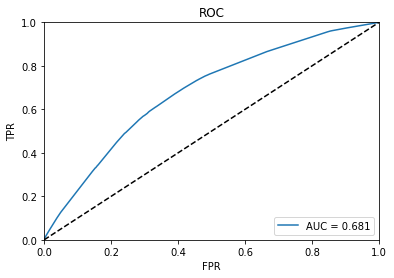

In [14]:
# Logistic Regression: nationality only 
start_time = time.time()
CAT_FEATURES = ['nat']
NUM_FEATURES = []
IMPUTE_METHODS = {'nat': 'none'}
MODEL = (LogisticRegression())

X_train, X_test, y_train, y_test = dp.get_model_data(dunn_with_appeals, 
                                                  label='has_appealed', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
metrics = dp.train_model(MODEL, X_train, y_train, X_test, y_test, plot_auc=True)
print("Model took {} seconds".format((time.time() - start_time)))
for metric, val in metrics.items():
    print(metric + " : " + str(val))

Training Data: (389096, 1) | Test Data: (97275, 1)
Model took 0.594508171081543 seconds
Accuracy : 0.740406065279
ROC AUC : 0.50411702695
Log Loss : 0.572611798699


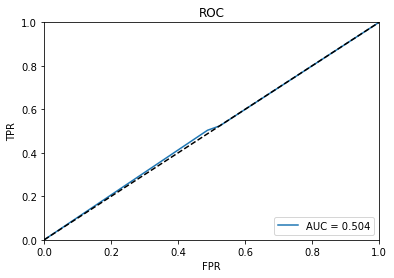

In [15]:
# Logistic Regression: nationality only 
start_time = time.time()
CAT_FEATURES = []
NUM_FEATURES = ['affirmative']
IMPUTE_METHODS = {'affirmative': 'mean'}
MODEL = (LogisticRegression())

X_train, X_test, y_train, y_test = dp.get_model_data(dunn_with_appeals, 
                                                  label='has_appealed', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
metrics = dp.train_model(MODEL, X_train, y_train, X_test, y_test, plot_auc=True)
print("Model took {} seconds".format((time.time() - start_time)))
for metric, val in metrics.items():
    print(metric + " : " + str(val))

Training Data: (389096, 225) | Test Data: (97275, 225)
Model took 15.497303009033203 seconds
Accuracy : 0.748393729118
ROC AUC : 0.680464458516
Log Loss : 0.532336984128


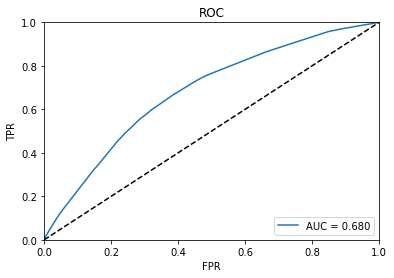

In [16]:
# nationality only 
start_time = time.time()
CAT_FEATURES = ['nat']
NUM_FEATURES = []
IMPUTE_METHODS = {'nat': 'none'}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = dp.get_model_data(dunn_with_appeals, 
                                                  label='has_appealed', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
metrics = dp.train_model(MODEL, X_train, y_train, X_test, y_test, plot_auc=True)
print("Model took {} seconds".format((time.time() - start_time)))
for metric, val in metrics.items():
    print(metric + " : " + str(val))

Training Data: (389096, 720) | Test Data: (97275, 720)
Model took 16.109423875808716 seconds
Accuracy : 0.766743767669
ROC AUC : 0.738772456094
Log Loss : 0.498786190581


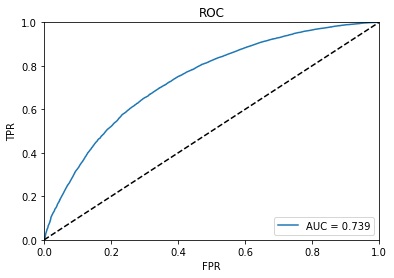

In [17]:
# Logistic Regression with nationality, judge, state, and year 
start_time = time.time()
CAT_FEATURES = ['nat', 'ij_code', 'base_city_state', 'adj_year']
NUM_FEATURES = ['affirmative']
IMPUTE_METHODS = {'nat': 'none', 'ij_code': 'none', 'base_city_state': 'none', 
                  'adj_year': 'none', 'affirmative': 'mean'}
MODEL = (LogisticRegression())

X_train, X_test, y_train, y_test = dp.get_model_data(dunn_with_appeals, 
                                                  label='has_appealed', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
metrics = dp.train_model(MODEL, X_train, y_train, X_test, y_test, plot_auc=True)
print("Model took {} seconds".format((time.time() - start_time)))
for metric, val in metrics.items():
    print(metric + " : " + str(val))

0.05
Training Data: (389096, 720) | Test Data: (97275, 720)
Model took 14.974259853363037 seconds
Accuracy : 0.766702647134
ROC AUC : 0.737262709811
Log Loss : 0.499577591484
0.1
Training Data: (389096, 720) | Test Data: (97275, 720)
Model took 16.210333824157715 seconds
Accuracy : 0.766414803392
ROC AUC : 0.738123693839
Log Loss : 0.499050084177
0.2
Training Data: (389096, 720) | Test Data: (97275, 720)
Model took 15.588186025619507 seconds
Accuracy : 0.766836288872
ROC AUC : 0.738529068529
Log Loss : 0.498845731944
0.5
Training Data: (389096, 720) | Test Data: (97275, 720)
Model took 14.717392921447754 seconds
Accuracy : 0.766784888204
ROC AUC : 0.738722600283
Log Loss : 0.498785859956
0.75
Training Data: (389096, 720) | Test Data: (97275, 720)
Model took 15.407679080963135 seconds
Accuracy : 0.766712927268
ROC AUC : 0.738755032347
Log Loss : 0.4987852134
1
Training Data: (389096, 720) | Test Data: (97275, 720)
Model took 16.633198022842407 seconds
Accuracy : 0.766743767669
ROC AUC :

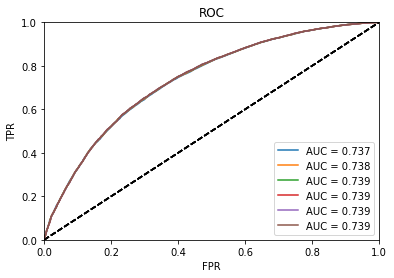

In [18]:
# Logistic Regression with nationality, judge, state, and year 
# Searching over the regularization param
CAT_FEATURES = ['nat', 'ij_code', 'base_city_state', 'adj_year']
NUM_FEATURES = ['affirmative']
IMPUTE_METHODS = {'nat': 'none', 'ij_code': 'none', 'base_city_state': 'none', 
                  'adj_year': 'none', 'affirmative': 'mean'}

MODELS = [(LogisticRegression(C=.05)), (LogisticRegression(C=.1)), (LogisticRegression(C=.2)),
          (LogisticRegression(C=.5)), (LogisticRegression(C=.75)), (LogisticRegression(C=1))]

log_losses = []
for MODEL in MODELS:
    start_time = time.time()
    print(MODEL.C)
    X_train, X_test, y_train, y_test = dp.get_model_data(dunn_with_appeals, 
                                                      label='has_appealed', cat_features = CAT_FEATURES, 
                                                      num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
    metrics = dp.train_model(MODEL, X_train, y_train, X_test, y_test, plot_auc=True)
    print("Model took {} seconds".format((time.time() - start_time)))
    for metric, val in metrics.items():
        print(metric + " : " + str(val))
        if metric == "Log Loss":
            log_losses.append((MODEL.C, val))
        

In [10]:
print(log_losses)

[(0.01, 0.62170638192823646), (0.1, 0.61829267788286402), (0.5, 0.61821419456687798), (1, 0.61822617829363624), (10, 0.61825259326865845), (100, 0.61828156002894519)]


Training Data: (389096, 720) | Test Data: (97275, 720)
Model took 64.50016927719116 seconds
Accuracy : 0.780683628887
ROC AUC : 0.769024652095
Log Loss : 0.79261256592


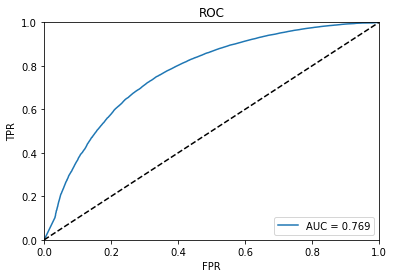

In [20]:
# nationality, judge, state, and year 
start_time = time.time()
CAT_FEATURES = ['nat', 'ij_code', 'base_city_state', 'adj_year']
NUM_FEATURES = ['affirmative']
IMPUTE_METHODS = {'nat': 'none', 'ij_code': 'none', 'base_city_state': 'none', 
                  'adj_year': 'none', 'affirmative': 'mean'}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = dp.get_model_data(dunn_with_appeals, 
                                                  label='has_appealed', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
metrics = dp.train_model(MODEL, X_train, y_train, X_test, y_test, plot_auc=True)
print("Model took {} seconds".format((time.time() - start_time)))
for metric, val in metrics.items():
    print(metric + " : " + str(val))

### Process the Chen data

In [19]:
dchen_df = pd.read_csv(os.path.join(DATAFOLDER, 'final_subset.csv'), low_memory=False) 
print("raw: " + str(dchen_df.shape))
# drop records with no case number, proceeding number, or decision 
dchen_df.dropna(subset=['case_id', 'proceeding_id', 'decision'], inplace=True) 
dchen_df = dchen_df[dchen_df['proceeding_id'] != 0] # drop zeros 
print(dchen_df.shape)
# convert indexes to integers 
dchen_df['case_id'] = dchen_df['case_id'].astype(int) 
dchen_df['proceeding_id'] = dchen_df['proceeding_id'].astype(int) 


raw: (5664752, 8)
(5664420, 8)


In [20]:
dchen_with_appeals = dchen_df.merge(appeals_in_scope, how='left', 
                                    left_on=['case_id', 'proceeding_id'], 
                                    right_on=['idncase', 'idnProceeding'])
dchen_with_appeals.head(5)

,case_id,proceeding_id,year,judge_id,nationality,lawyer,city_id,decision,idncase,idnProceeding,strBIADecision,strAppealTypeDesc,strAppealCategoryDesc
0,2046921,3200049,2004.0,325,MX,0,9,REMOVE,NaN,NaN,NaN,NaN,NaN
1,2046922,3200050,2004.0,194,MX,0,9,REMOVE,NaN,NaN,NaN,NaN,NaN
2,2046923,3200051,2004.0,56,PL,1,9,REMOVE,2046923.0,3200051.0,REM,Case Appeal,NaN
3,2046923,3525150,2005.0,133,PL,1,9,TRANSFER,NaN,NaN,NaN,NaN,NaN
4,2046923,3538044,2005.0,56,PL,1,9,RELIEF GRANTED,NaN,NaN,NaN,NaN,NaN


In [11]:
granted_decisions = ['Background Check Remand', 'Grant With No Remand', 'Granted', 'Remand', 
                     'Sustain', 'Temporary Protected Status']
denied_decisions = ['Denied', "Dismiss Appeal/Affirm IJ's Decision", 'Dismissed (Grant V/D 30 days)', 
                    'Dismissed (Voluntary Departure Granted)', 'Rejection', 'SUMMARY AFFIRMANCE/VD', 
                    'Summary Affirmance', 'Summary Dismiss', 'Summary Dismissal (O) Other', 
                    'Summary Dismissal (a) inad reason on appeal', 'Summary Dismissal - Both (a) & (e)']
for decision in sorted(dchen_with_appeals.decision.unique()):
    print(decision)

ABANDONMENT
ADMINISTRATIVE CLOSING - OTHER
ADMIT
AFFIRMED - DHS DECISION
AFFIRMED - DHS DECISION AND NO CREDIBLE FEAR
CHANGE OF VENUE
CONDITIONAL GRANT
DENY
DEPORT
DHS DECISION AND NO REASONABLE FEAR
DHS DECISION AND REASONABLE FEAR
DISMISSED
EXCLUDE
FAILURE TO PROSECUTE (DHS CASES ONLY)
GRANT
HAITIAN
JURISDICTION TRANSFERRED TO THE BIA
OTHER
OTHER ADMINISTRATIVE COMPLETION
PROSECUTORIAL DISCRETION Ð ADMIN CLOSE
PROSECUTORIAL DISCRETION Ð TERMINATED
RELIEF GRANTED
REMOVE
RESCIND
SUSTAIN
TEMPORARY PROTECTED STATUS
TERMINATE
TERMINATED
TRANSFER
VACATE - DHS DECISION AND ALIEN'S CLAIMED STATUS VALID
VACATE - DHS DECISION AND CREDIBLE FEAR
VOLUNTARY DEPARTURE
WITHDRAW
ZERO BOND


In [21]:
# Need to remove cases where the appeal was granted because 

dchen_with_appeals['has_appealed'] = np.where(dchen_with_appeals['idncase'].isnull(), 0 ,1)
dchen_with_appeals.head(5)

,case_id,proceeding_id,year,judge_id,nationality,lawyer,city_id,decision,idncase,idnProceeding,strBIADecision,strAppealTypeDesc,strAppealCategoryDesc,has_appealed
0,2046921,3200049,2004.0,325,MX,0,9,REMOVE,NaN,NaN,NaN,NaN,NaN,0
1,2046922,3200050,2004.0,194,MX,0,9,REMOVE,NaN,NaN,NaN,NaN,NaN,0
2,2046923,3200051,2004.0,56,PL,1,9,REMOVE,2046923.0,3200051.0,REM,Case Appeal,NaN,1
3,2046923,3525150,2005.0,133,PL,1,9,TRANSFER,NaN,NaN,NaN,NaN,NaN,0
4,2046923,3538044,2005.0,56,PL,1,9,RELIEF GRANTED,NaN,NaN,NaN,NaN,NaN,0


In [25]:
#dchen_with_appeals.describe()
#df[['col1', 'col2', 'col3', 'col4']].groupby(['col1', 'col2']).agg(['mean', 'count'])
dchen_with_appeals[['has_appealed', 'decision']].groupby(['decision']).agg(['sum'])


,has_appealed
,sum
decision,
ABANDONMENT,6
ADMINISTRATIVE CLOSING - OTHER,1271
ADMIT,915
AFFIRMED - DHS DECISION,7
AFFIRMED - DHS DECISION AND NO CREDIBLE FEAR,98
CHANGE OF VENUE,813
CONDITIONAL GRANT,8
DENY,6155


In [ ]:
cat_feature_values = dict([(f, df[f].dropna().unique().tolist()) for f in cat_features]) # do EDA and limit to smaller list 

dummify = dp.get_model_data(cat_feature_values)
dchen_with_appeals_dum = dummify.transform(dchen_with_appeals)
dchen_with_appeals_dum.head()

Training Data: (4677468, 265) | Test Data: (1169368, 265)


{'Accuracy': 0.87299806391144619,
 'Log Loss': 0.35425033550190788,
 'ROC AUC': 0.68443368354521084}

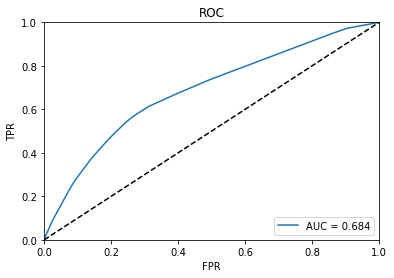

In [8]:
# nationality only 
CAT_FEATURES = ['nationality']
NUM_FEATURES = []
IMPUTE_METHODS = {'nationality': 'none'}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = dp.get_model_data(dchen_with_appeals, 
                                                  label='has_appealed', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
metrics = dp.train_model(MODEL, X_train, y_train, X_test, y_test, plot_auc=True)
print(metrics)

Training Data: (4677468, 763) | Test Data: (1169368, 763)


{'Accuracy': 0.87299806391144619,
 'Log Loss': 0.32461330183637005,
 'ROC AUC': 0.77056192173118887}

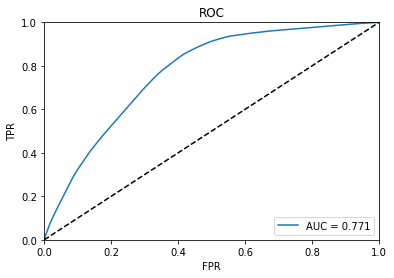

In [10]:
CAT_FEATURES = ['nationality', 'judge_id', 'year']
NUM_FEATURES = ['lawyer']
IMPUTE_METHODS = {'nationality': 'none', 'judge_id': 'none', 'year': 'none', 'lawyer': 'zero'}
MODEL = (RandomForestClassifier(n_estimators=10))

X_train, X_test, y_train, y_test = dp.get_model_data(dchen_with_appeals, 
                                                  label='has_appealed', cat_features = CAT_FEATURES, 
                                                  num_features = NUM_FEATURES, impute_methods = IMPUTE_METHODS) 
dp.train_model(MODEL, X_train, y_train, X_test, y_test, plot_auc=True)